In [1]:
# Importing all the libraries necessary

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
import sklearn 
import scipy.stats


from matplotlib import figure
from IPython.display import Image


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


#from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, make_scorer, silhouette_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, KFold


from scipy.stats import chi2

In [2]:
# Exploring The Data

df_explore = pd.read_csv('BankChurners.csv')
df_explore.info

<bound method DataFrame.info of        CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0      768805383  Existing Customer            45      M                3   
1      818770008  Existing Customer            49      F                5   
2      713982108  Existing Customer            51      M                3   
3      769911858  Existing Customer            40      F                4   
4      709106358  Existing Customer            40      M                3   
...          ...                ...           ...    ...              ...   
10122  772366833  Existing Customer            50      M                2   
10123  710638233  Attrited Customer            41      M                2   
10124  716506083  Attrited Customer            44      F                1   
10125  717406983  Attrited Customer            30      M                2   
10126  714337233  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income

In [3]:
# Printing out all the columns

df_explore.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

## Data Cleaning

In [4]:
# Dropping the Naive_Bayes_Classifier columns (There are 2 in the dataset)

df = df_explore.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
df.columns 

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [5]:
# Listing all the columns in the dataset and lookinng some info about the data
print('-------------Columns-------------')
print(list(df.columns))
print('\n')
print('-------------Dataset-------------')
display(df.info)

-------------Columns-------------
['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


-------------Dataset-------------


<bound method DataFrame.info of        CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0      768805383  Existing Customer            45      M                3   
1      818770008  Existing Customer            49      F                5   
2      713982108  Existing Customer            51      M                3   
3      769911858  Existing Customer            40      F                4   
4      709106358  Existing Customer            40      M                3   
...          ...                ...           ...    ...              ...   
10122  772366833  Existing Customer            50      M                2   
10123  710638233  Attrited Customer            41      M                2   
10124  716506083  Attrited Customer            44      F                1   
10125  717406983  Attrited Customer            30      M                2   
10126  714337233  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income

In [6]:
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [7]:
#Check for duplicate
print('---Check for duplicate---')
print(df[df.duplicated(keep=False)])
print('\n')

print('---Check for duplicate IDS---')
print(df.duplicated(subset=['CLIENTNUM']).unique())
print('\n')

#check for Unknown Values
print('---Check for Unknowns---')
print(df[df == 'Unknown'].count())
print('\n')

#Check for Zero Values
print('---Check for 0 Values---')
df[df == 0].count()


---Check for duplicate---
Empty DataFrame
Columns: [CLIENTNUM, Attrition_Flag, Customer_Age, Gender, Dependent_count, Education_Level, Marital_Status, Income_Category, Card_Category, Months_on_book, Total_Relationship_Count, Months_Inactive_12_mon, Contacts_Count_12_mon, Credit_Limit, Total_Revolving_Bal, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt, Total_Trans_Ct, Total_Ct_Chng_Q4_Q1, Avg_Utilization_Ratio]
Index: []

[0 rows x 21 columns]


---Check for duplicate IDS---
[False]


---Check for Unknowns---
CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count              904
Education_Level                0
Marital_Status                 0
Income_Category                0
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon        29
Contacts_Count_12_mon        399
Credit_Limit                   0
Total_Revolving_Bal         2470
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           5
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            7
Avg_Utilization_Ratio       2470
dtype: int64

In [8]:
# Counting the Attrition Flags

aggregate_data = df.groupby(['Attrition_Flag'])['CLIENTNUM'].count().to_frame().reset_index()
aggregate_data

,Attrition_Flag,CLIENTNUM
0,Attrited Customer,1627
1,Existing Customer,8500


## Converting Categorical Data into Numerical Data

In [10]:
cat_to_num = [
    "Attrition_Flag",
    "Gender",
    "Education_Level",
    "Marital_Status",
    "Income_Category",
    "Card_Category"
]

cat_mapping = dict()
lenc = LabelEncoder()
for c in cat_to_num:
    cat_mapping[c] = lenc.fit_transform(df.loc[:, c])
cat_df = pd.DataFrame(cat_mapping)

In [11]:
numerical_features = [f for f in df.columns if f not in cat_to_num]
df_numerical = df.loc[:, numerical_features]

In [12]:
df_main = pd.concat([cat_df, df_numerical], axis=1)
display(df_main.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  int32  
 1   Gender                    10127 non-null  int32  
 2   Education_Level           10127 non-null  int32  
 3   Marital_Status            10127 non-null  int32  
 4   Income_Category           10127 non-null  int32  
 5   Card_Category             10127 non-null  int32  
 6   CLIENTNUM                 10127 non-null  int64  
 7   Customer_Age              10127 non-null  int64  
 8   Dependent_count           10127 non-null  int64  
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

None

In [13]:
df_main.head(20)

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,1,3,1,2,0,768805383,45,3,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,0,2,2,4,0,818770008,49,5,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,1,2,1,3,0,713982108,51,3,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,1,0,3,3,4,0,769911858,40,4,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,1,1,5,1,2,0,709106358,40,3,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,1,1,2,1,1,0,713061558,44,2,36,...,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
6,1,1,6,1,0,1,810347208,51,4,46,...,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
7,1,1,3,3,2,3,818906208,32,0,27,...,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
8,1,1,5,2,2,0,710930508,37,3,36,...,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
9,1,1,2,2,3,0,719661558,48,2,36,...,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144


C:\Users\ziyad\AppData\Local\Temp\ipykernel_22836\3865090664.py:4: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.

C:\Users\ziyad\AppData\Local\Temp\ipykernel_22836\3865090664.py:5: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



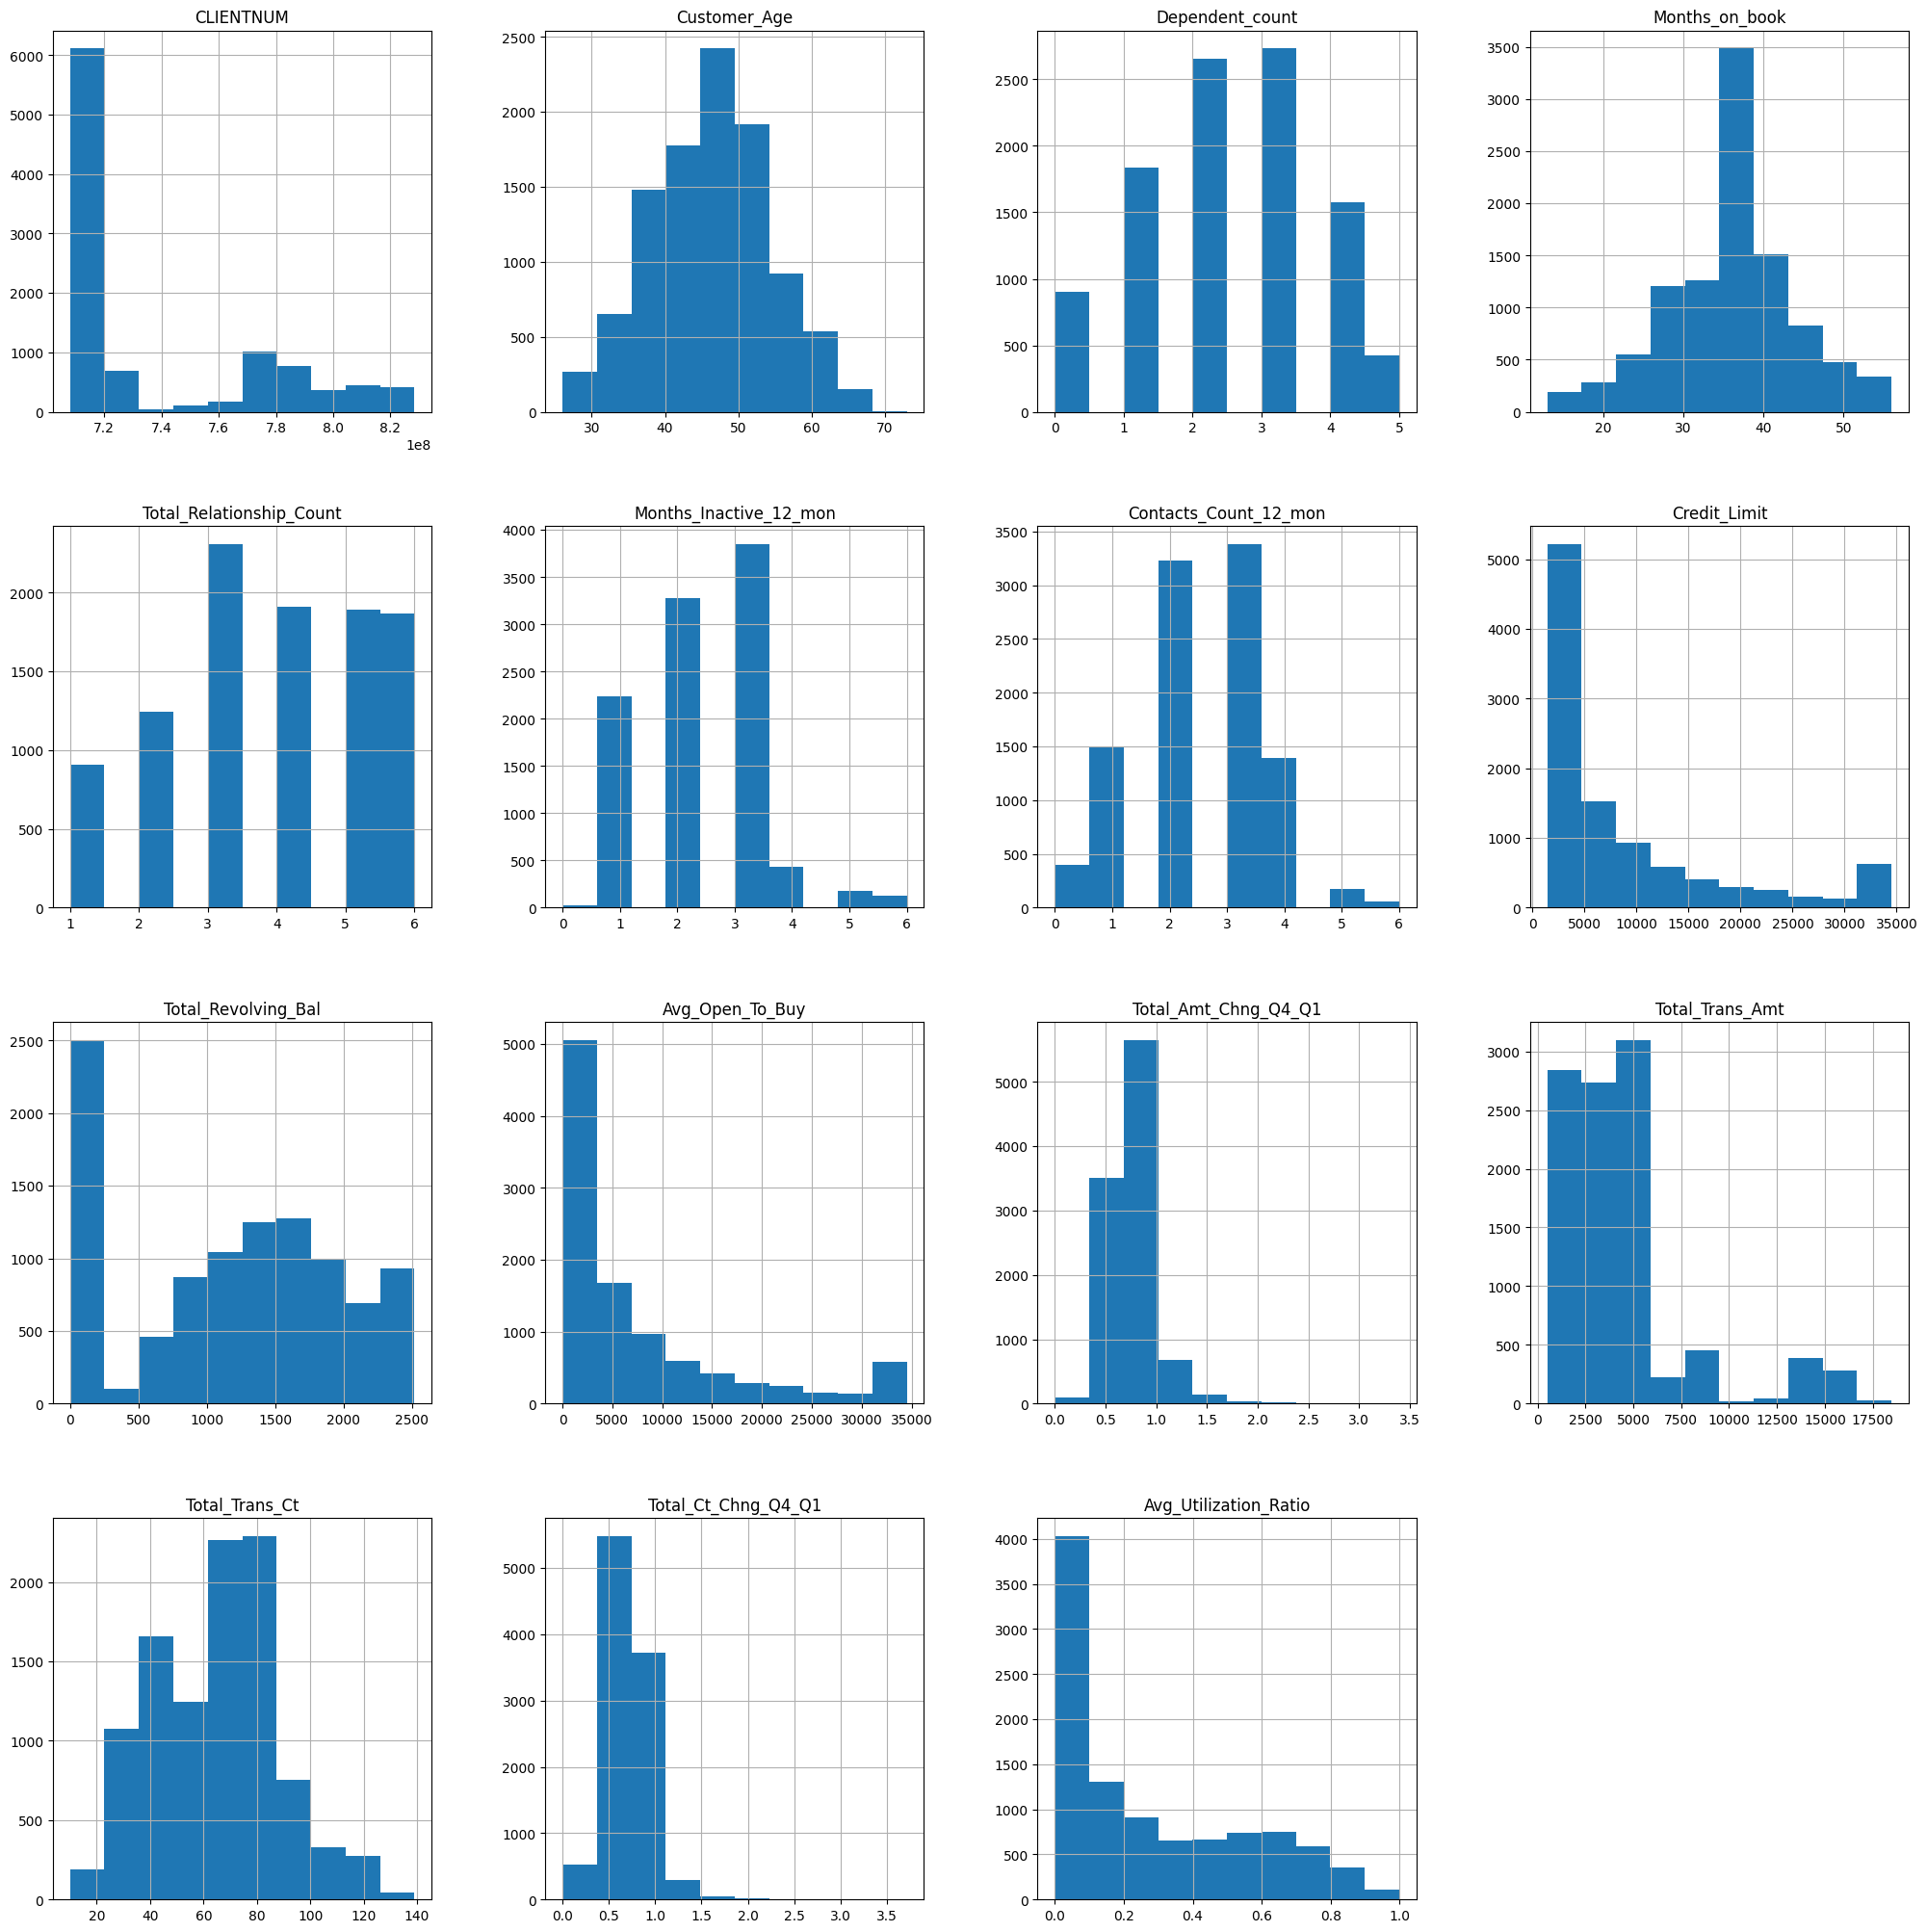

In [46]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
plt.tight_layout()
df.loc[:, ~df_main.columns.isin(['CLIENTNUM', "Attrition_Flag_Int"])].hist(ax = ax)
fig.show()

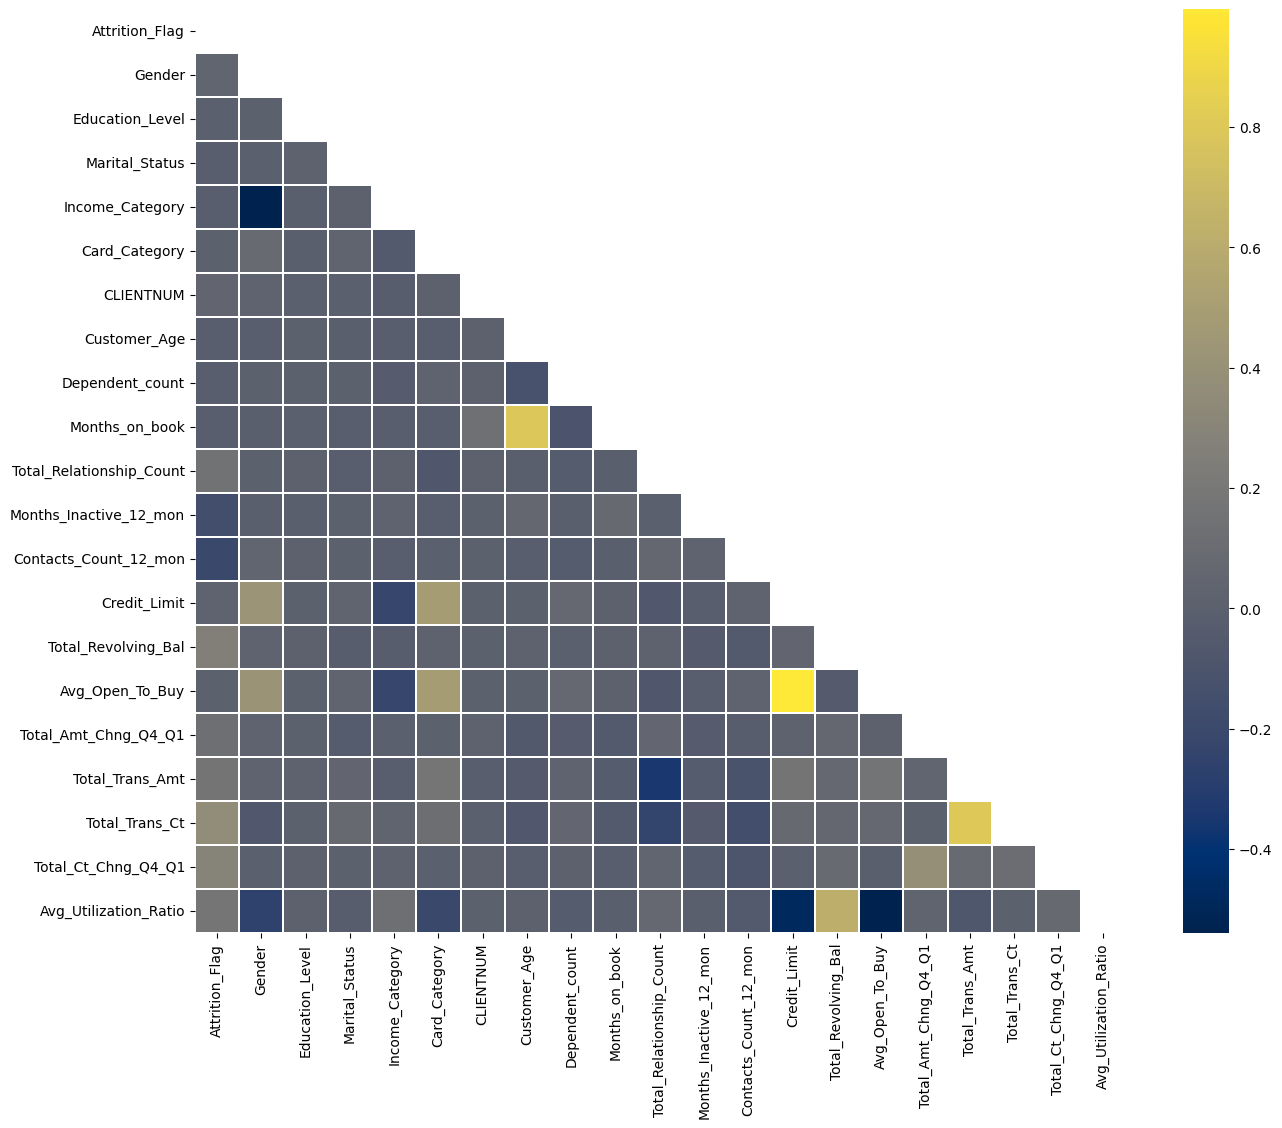

In [14]:
corr_df = df_main.corr()

mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_df, cmap="cividis", linewidth=0.15, mask=mask);

C:\Users\ziyad\AppData\Local\Temp\ipykernel_22836\3473811730.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.loc[:, ~df.columns.isin(['CLIENTNUM'])].corr().round(2)


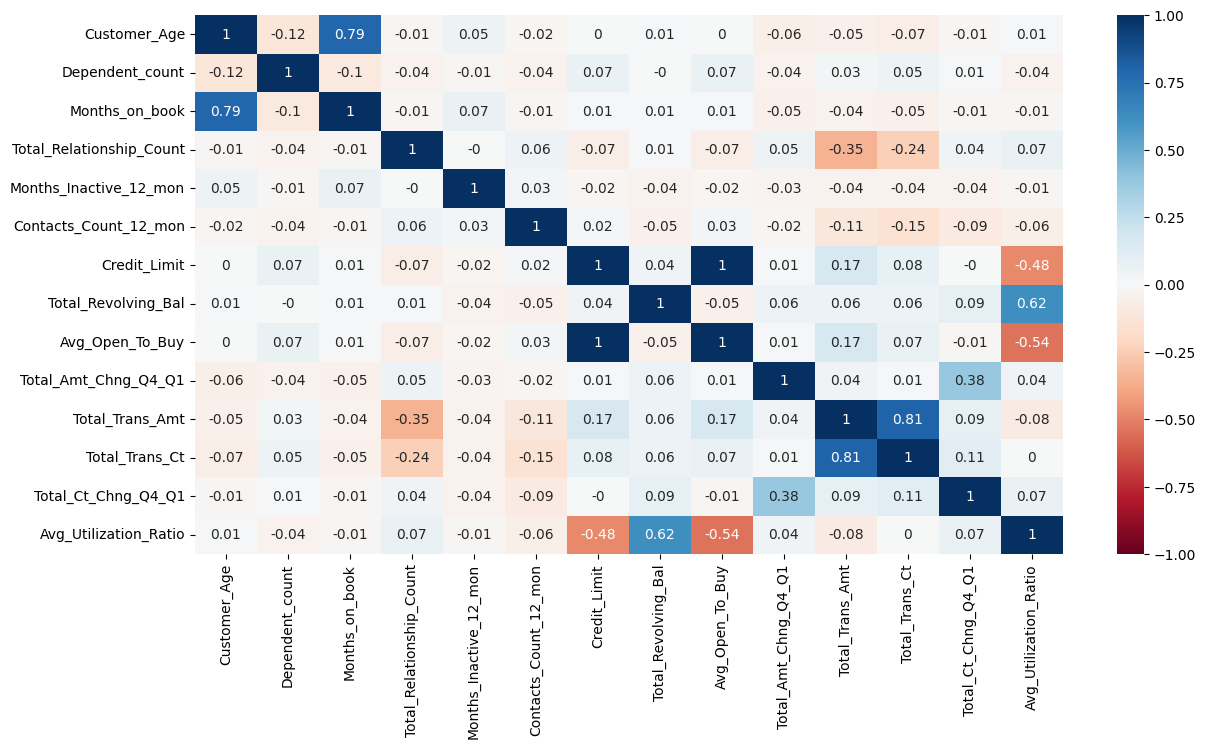

In [15]:
correlation = df.loc[:, ~df.columns.isin(['CLIENTNUM'])].corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True, cmap = 'RdBu', vmin=-1, vmax=1)
plt.show()


In [16]:
# Counting the Attrition Flags
# Attrited Customer = 0, Existing Customer = 1.

aggregate_data = df_main.groupby(['Attrition_Flag'])['CLIENTNUM'].count().to_frame().reset_index()
aggregate_data

,Attrition_Flag,CLIENTNUM
0,0,1627
1,1,8500


[Text(0, 0, '8500'), Text(0, 0, '1627')]

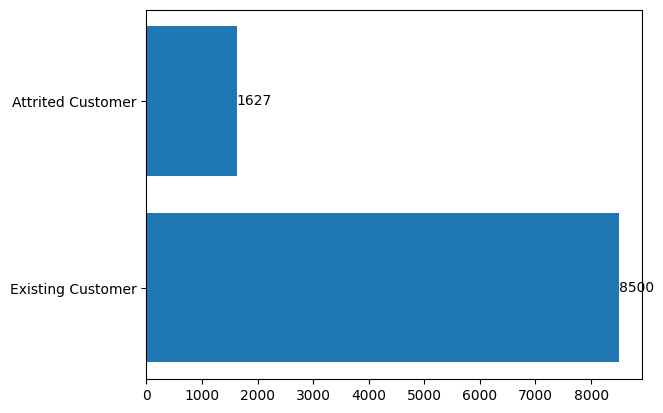

In [17]:


x = ['Existing Customer','Attrited Customer']
y = [df['Attrition_Flag'].value_counts()[0],df['Attrition_Flag'].value_counts()[1]]
fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)


In [18]:
# A pie plot to better represent the data

labels = aggregate_data.Attrition_Flag
values = aggregate_data.CLIENTNUM

fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0.2])])
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.90,
    xanchor="left",
    x=0.20
))

## Measuring feature importance with respect to attrition flag

In [19]:
X_data = df_main[[i for i in df_main.columns if i != "Attrition_Flag"]]
y_data = df_main["Attrition_Flag"]

In [20]:
params = {
    "max_depth": range(1, 9),
    "min_samples_split": [5, 7, 9, 12, 15],
    "min_samples_leaf": [5, 7, 9, 10, 12]
}

s_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

estimator = RandomForestClassifier(random_state=42)
scoring = make_scorer(f1_score)

grid_search = GridSearchCV(
    estimator=estimator, 
    param_grid=params, 
    scoring=scoring, 
    cv=s_kfold, 
    n_jobs=-1
)

search_results = grid_search.fit(X_data, y_data)

best_params = search_results.best_params_
best_score = search_results.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 15}
Best score: 0.9672994684011581


In [21]:
search_results.best_params_

{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 15}

In [22]:
fi = pd.Series(search_results.best_estimator_.feature_importances_, index = X_data.columns)
fi

Gender                      0.007973
Education_Level             0.001810
Marital_Status              0.002889
Income_Category             0.004264
Card_Category               0.000735
CLIENTNUM                   0.007766
Customer_Age                0.018100
Dependent_count             0.003545
Months_on_book              0.010033
Total_Relationship_Count    0.079702
Months_Inactive_12_mon      0.021845
Contacts_Count_12_mon       0.017897
Credit_Limit                0.021925
Total_Revolving_Bal         0.130040
Avg_Open_To_Buy             0.018592
Total_Amt_Chng_Q4_Q1        0.049282
Total_Trans_Amt             0.215404
Total_Trans_Ct              0.191910
Total_Ct_Chng_Q4_Q1         0.113417
Avg_Utilization_Ratio       0.082870
dtype: float64

In [23]:
important_features = fi[fi >= 0.04].index.to_list()
important_features

['Total_Relationship_Count',
 'Total_Revolving_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [24]:
reduced_data = df_main.loc[:,['Total_Revolving_Bal',
 'Total_Relationship_Count',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Amt_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
'Attrition_Flag']]

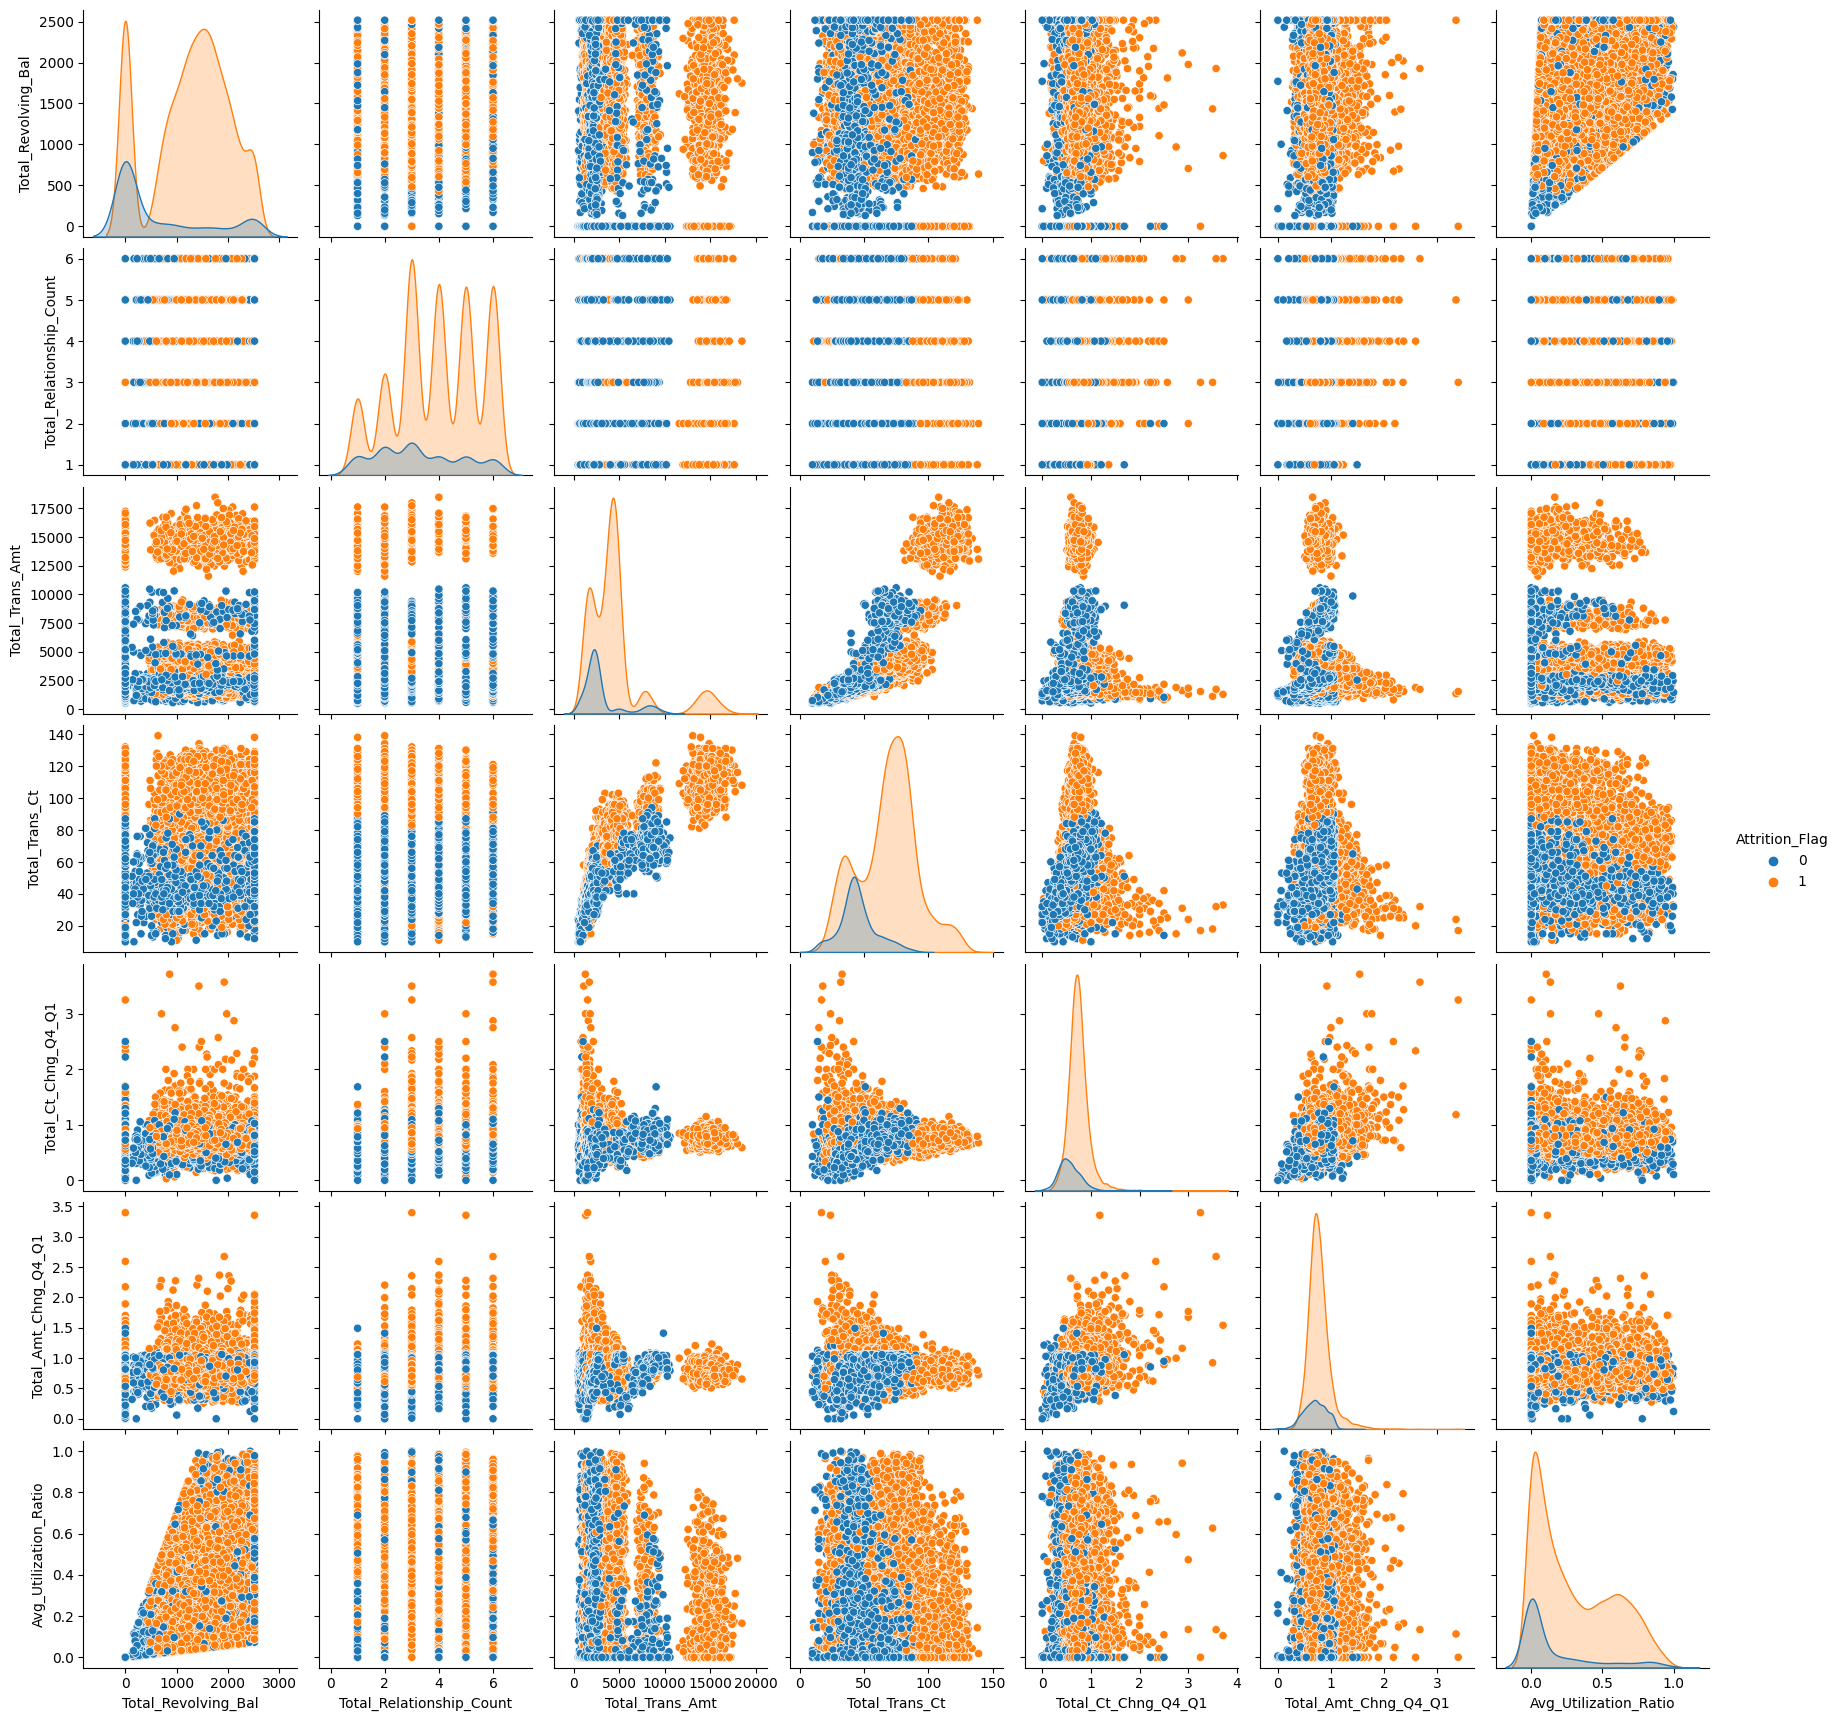

In [25]:
sns.pairplot(reduced_data, hue='Attrition_Flag', diag_kind='kde');

In [26]:
std_scaler = StandardScaler()
reduced_data = std_scaler.fit_transform(reduced_data)

std_scaler2 = StandardScaler()
full_data = std_scaler2.fit_transform(df_main)

## CLustering for KMeans

In [27]:
lis_main = []
sil_score_main = []
for k in range(2, 20):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(full_data)
    predict = model.fit_predict(full_data)

    lis_main.append(model.inertia_)
    sil_score_main.append(silhouette_score(full_data,predict))

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:8

In [28]:
lis = []
sil_score_reduced = []
for k in range(2, 20):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(reduced_data)
    predict = model.fit_predict(reduced_data)

    lis.append(model.inertia_)
    sil_score_reduced.append(silhouette_score(reduced_data,predict))

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:8

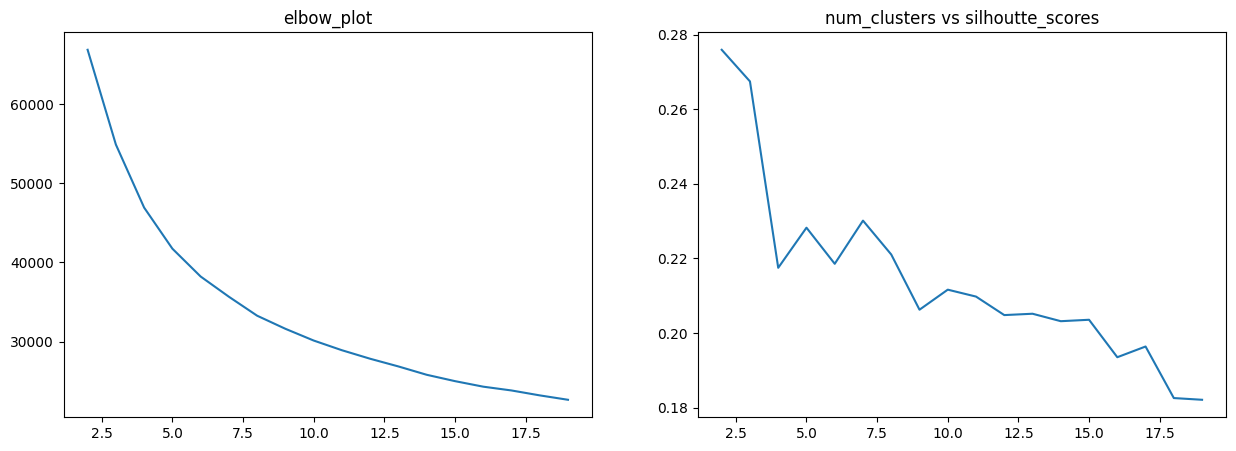

In [29]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x=range(2,20), y=lis, ax=ax[0])
ax[0].set_title("elbow_plot");

sns.lineplot(x=range(2,20), y=sil_score_reduced, ax=ax[1])
ax[1].set_title("num_clusters vs silhoutte_scores");

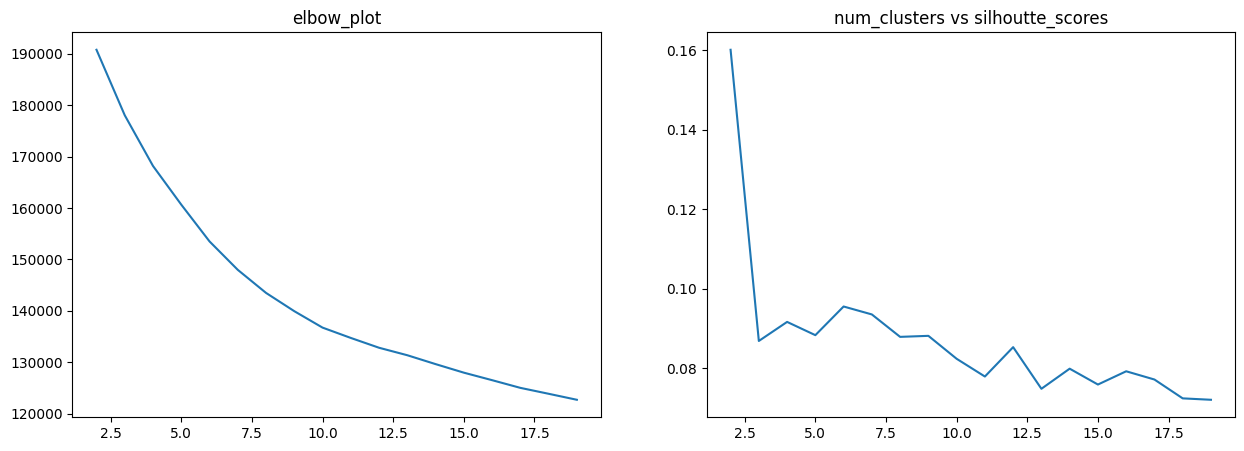

In [30]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x=range(2,20), y=lis_main, ax=ax[0])
ax[0].set_title("elbow_plot");

sns.lineplot(x=range(2,20), y=sil_score_main, ax=ax[1])
ax[1].set_title("num_clusters vs silhoutte_scores");

silhoutte score at K = 6. This is the best one we could get. 

In [31]:
kmeans_model = KMeans(n_clusters=6, random_state=42)
kmeans_model.fit(reduced_data)
kmeans_prediction = kmeans_model.fit_predict(reduced_data)

silhouette_score(reduced_data,kmeans_prediction)

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\ziyad\.conda\envs\env_ML\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



0.2185546719412025

### The silhoutte score is quite low so it does not seem to be a good method for this data set as the silhouette score defines how close are the data points to the said clusters and can help determine if the classification is valid. Due to this, we can not rely on this method due to the ambiguity being present in the data set and thus resulting in a low score. 

## Applying KNN



In [32]:
x = df_main.drop(columns=['Attrition_Flag'])
y = df_main['Attrition_Flag']
x.shape, y.shape

((10127, 20), (10127,))

In [33]:
x.head(20)

,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,1,3,1,2,0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,2,2,4,0,818770008,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,2,1,3,0,713982108,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,3,3,4,0,769911858,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,1,5,1,2,0,709106358,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,1,2,1,1,0,713061558,44,2,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
6,1,6,1,0,1,810347208,51,4,46,6,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
7,1,3,3,2,3,818906208,32,0,27,2,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
8,1,5,2,2,0,710930508,37,3,36,5,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
9,1,2,2,3,0,719661558,48,2,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144


In [34]:
# StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance

X = StandardScaler().fit_transform(x)
X[:3]

array([[ 1.05995565e+00, -5.26365976e-02, -6.28127573e-01,
        -5.74181504e-01, -2.59473284e-01,  8.02878101e-01,
        -1.65405580e-01,  5.03368127e-01,  3.84620878e-01,
         7.63942609e-01, -1.32713603e+00,  4.92403766e-01,
         4.46621903e-01, -4.73422218e-01,  4.88970818e-01,
         2.62349444e+00, -9.59706574e-01, -9.73895182e-01,
         3.83400260e+00, -7.75882235e-01],
       [-9.43435701e-01, -5.97678339e-01,  7.27305611e-01,
         7.55052944e-01, -2.59473284e-01,  2.15686101e+00,
         3.33570383e-01,  2.04319867e+00,  1.01071482e+00,
         1.40730617e+00, -1.32713603e+00, -4.11615984e-01,
        -4.13666521e-02, -3.66666822e-01, -8.48598788e-03,
         3.56329284e+00, -9.16432607e-01, -1.35734038e+00,
         1.26085729e+01, -6.16275655e-01],
       [ 1.05995565e+00, -5.97678339e-01, -6.28127573e-01,
         9.04357198e-02, -2.59473284e-01, -6.82768542e-01,
         5.83058365e-01,  5.03368127e-01,  8.96451285e-03,
         1.20579050e-01, -1.3

In [35]:
# Creating Test and Train split for KNN.

x_train, x_test, y_train, y_test = train_test_split(X,y,stratify=y)


In [36]:
# Fucntion to check for different K - Nearest neighbors

def knn_scores(X, y, start, stop, step):
    list_scores = []
    for i in range(start,stop,step):
        model = KNeighborsClassifier(n_neighbors=i)
        kfold = KFold(n_splits=10, shuffle=True, random_state=44)
        cross_val_scores_KNN = cross_val_score(model, X,y,cv=kfold)
        dict_row_score = {'mean_score': np.mean(cross_val_scores_KNN), 'std_score': np.std(cross_val_scores_KNN), 'n_neighbours' :i}
        list_scores.append(dict_row_score)

    df_knn_scores = pd.DataFrame(list_scores)

    df_knn_scores['Lower_Bound'] = df_knn_scores['mean_score'] - df_knn_scores['std_score']
    df_knn_scores['Upper_Bound'] = df_knn_scores['mean_score'] + df_knn_scores['std_score']

    return df_knn_scores


In [37]:
# Try 1 to 20 neigbours
df_knn_scores = knn_scores(x_train, y_train, 1, 21, 1)

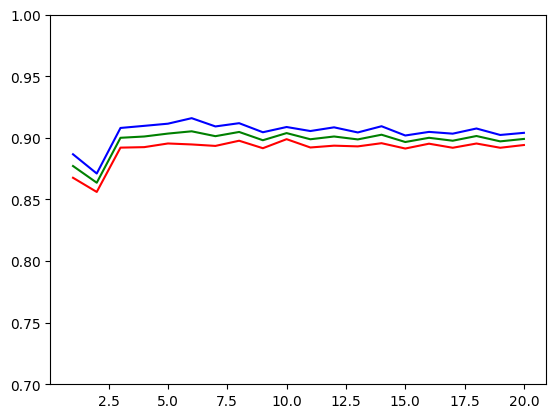

In [38]:
# Plotting best scorses.

plt.plot(df_knn_scores['n_neighbours'], df_knn_scores['Lower_Bound'], color ='r')
plt.plot(df_knn_scores['n_neighbours'], df_knn_scores['mean_score'], color ='g')
plt.plot(df_knn_scores['n_neighbours'], df_knn_scores['Upper_Bound'], color ='b')
plt.ylim(0.7,1);

In [39]:
# Check the hyperparameter with the higher score
df_knn_scores.loc[df_knn_scores.mean_score == df_knn_scores.mean_score.max()]

,mean_score,std_score,n_neighbours,Lower_Bound,Upper_Bound
5,0.905333,0.010665,6,0.894668,0.915998


In [40]:
best_k = df_knn_scores.loc[df_knn_scores.mean_score == df_knn_scores.mean_score.max(), 'n_neighbours'].values[0]
print('The best K is ' + str(best_k)) 
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train, y_train)

The best K is 6


KNeighborsClassifier(n_neighbors=6)

In [41]:
# Applying the model

y_knn_predict = model.predict(x_test)

In [42]:
# Calculating the Specificity score. 

confusion_knn=confusion_matrix(y_test, y_knn_predict)
TP = confusion_knn[1, 1]
TN = confusion_knn[0, 0]
FP = confusion_knn[0, 1]
FN = confusion_knn[1, 0]

specificity_knn = TN / (TN + FP)
print('The Specificity Score is ' + str(specificity_knn))

The Specificity Score is 0.5405405405405406


In [43]:
# Accuracy, Precision, Recall, F1 score

df_KNN = pd.DataFrame(classification_report(y_knn_predict,y_test, digits=2,output_dict=True)).T

df_KNN['support'] = df_KNN.support.apply(int)

df_KNN.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

,precision,recall,f1-score,support
0,0.540541,0.777385,0.637681,283
1,0.970353,0.916852,0.942844,2249
accuracy,0.901264,0.901264,0.901264,0
macro avg,0.755447,0.847119,0.790263,2532
weighted avg,0.922313,0.901264,0.908736,2532


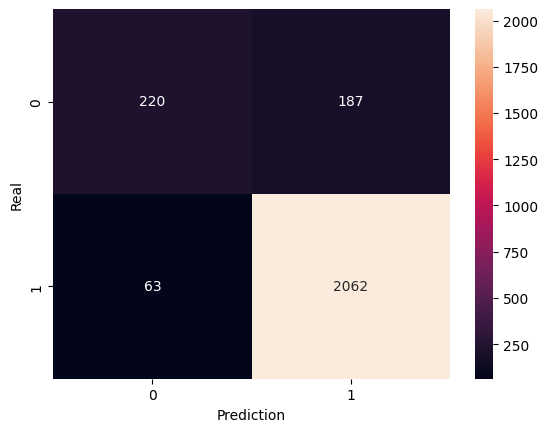

In [44]:
# Heat Map for KNN

sns.heatmap(confusion_matrix(y_test, y_knn_predict), annot=True, fmt='.0f')
plt.ylabel('Real')
plt.xlabel('Prediction');

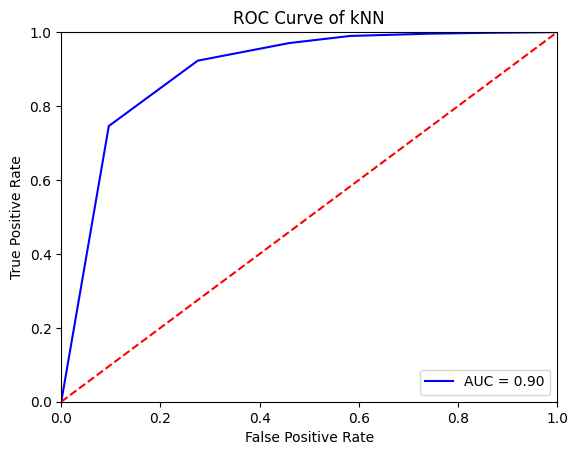

In [45]:
# ROC Curve of KNN

y_scores = model.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()